<a href="https://colab.research.google.com/github/seunghee0518/AI_python/blob/main/Outlier%20detection%20%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C%20%EC%82%AC%EA%B8%B0%EA%B1%B0%EB%9E%98%20%EA%B0%90%EC%A7%80/pycaret%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EB%AA%A8%EB%8D%B8_%EC%84%A0%EC%A0%95_%EB%B0%8F_GridSearchCV%EB%A1%9C_%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0_%EC%B5%9C%EC%A0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

pycaret을 사용하여 모델 선정 후 GridSearchCV로 파라미터 최적화 -> 제출
* class값이 있는 valid 데이터로 모델 성능비교
* https://velog.io/@ezoo0422/Python-pycaret%EC%9D%84-%EC%82%AC%EC%9A%A9%ED%95%98%EC%97%AC-%EB%AA%A8%EB%8D%B8-%EC%84%A0%EC%A0%95%ED%95%98%EA%B8%B0

## Import

In [ ]:
#!pip install pycaret
#!pip install Jinja2
!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq
!pip install pycaret[full]

In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

# import pycaret
# from pycaret.datasets import get_data
import jinja2
#from pycaret.classification import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Load

In [ ]:
directory = '/content/drive/MyDrive/DACON_신용카드 사기 거래 탐지 AI 경진대회'

In [ ]:
train_df = pd.read_csv(f'{directory}/data/train.csv') # Train
train_df.head()

val_df = pd.read_csv(f'{directory}/data/val.csv') # Validation
val_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,10,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,22,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,63,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,69,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,83,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0


# 스케일링

In [ ]:
## 스케일링 함수
def train_df_scaler(df) :
  df_columns = df.columns
  scaler = StandardScaler() 
  scaler.fit(df)
  result_df = pd.DataFrame(scaler.transform(df), columns = df_columns)
  return result_df

def vaild_df_scaler(df, label : str) :
  class_df = df[[f'{label}']]
  df = df.drop(columns=['Class'])
  df_columns = df.columns
  scaler = StandardScaler() 
  scaler.fit(df)
  result_df = pd.DataFrame(scaler.transform(df), columns = df_columns)
  result_df = pd.concat([result_df, class_df], axis = 1)
  return result_df

In [ ]:
train_data = train_df.drop(columns=['ID'])
train_data = train_df_scaler(train_data)

In [ ]:
valid_data = val_df.drop(columns=['ID'])
valid_data = vaild_df_scaler(valid_data, 'Class')

# GridSearchCV로 IsolationForest 최적 하이퍼파라미터 값 찾기

In [ ]:
val_normal, val_fraud = val_df['Class'].value_counts() # 0 : 28432 / 1 : 30
val_contamination = val_fraud / val_normal
print(f'Validation contamination : [{val_contamination}]')

Validation contamination : [0.0010551491277433877]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

param_if = {"n_estimators" : list(range(100, 200, 10)) 100, 110, 120 ```` 190 
            "contamination" : list(np.arange(0, 0.05, 0.001))} 0 0.001 ~ 0.05

#cv = StratifiedKFold(n_splits=3, shuffle = True, random_state=42)
gscv_IF = GridSearchCV(estimator = IsolationForest(),
                       param_grid = param_if,
                       scoring ='f1_micro', # f1_micro 데이터셋 불균형일 경우 더 유리
                       cv = StratifiedKFold(n_splits=3, shuffle = True, random_state=42), # 교차 검증을 위한 fold 수
                       refit=True,
                       n_jobs=1,
                       verbose=2)

valid_x = valid_data.drop(columns = ['Class']).to_numpy()
valid_y = valid_data.Class.to_numpy()
## IsolationForest은 정상 1, 이상치 -1로 구분하므로 맞춤 : 0 -> 1, 1 -> -1
valid_y = np.where(valid_y == 1, -1, valid_y)
valid_y = np.where(valid_y == 0, 1, valid_y)

start_time = datetime.now()
gscv_IF.fit(valid_x, valid_y)
elapsed_time = datetime.now() - start_time


#model = IsolationForest(n_estimators=125, max_samples=len(train_x), contamination=val_contamination, random_state=42, verbose=0)
'''
n_estimators : 앙상블에 있는 기본 추정량의 수입니다, 기본값 100, 노드 수, (랜덤포레스트는 늘리면 성능이 좋아짐)
contamination : 이상값 비율, float값일 경우 [0, 0.5] , 'auto' : 0.1
max_samples = len(train_x) -> 샘플링 없음, 모든 데이터 사용해서 모델 적합
max_features : 각 나무를 훈련할 때(분할시), 사용할 특징의 개수, 기본값 1
n_jobs : 학습시 컴퓨터 코어 사용 개수
verbose : 실행과정 출력여부
'''

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV] contamination=0.0, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. contamination=0.0, n_estimators=100, total=   1.8s
[CV] contamination=0.0, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] .............. contamination=0.0, n_estimators=100, total=   1.8s
[CV] contamination=0.0, n_estimators=100 .............................
[CV] .............. contamination=0.0, n_estimators=100, total=   1.7s
[CV] contamination=0.0, n_estimators=110 .............................
[CV] .............. contamination=0.0, n_estimators=110, total=   1.9s
[CV] contamination=0.0, n_estimators=110 .............................
[CV] .............. contamination=0.0, n_estimators=110, total=   1.9s
[CV] contamination=0.0, n_estimators=110 .............................
[CV] .............. contamination=0.0, n_estimators=110, total=   2.0s
[CV] contamination=0.0, n_estimators=120 .............................
[CV] .............. contamination=0.0, n_estimators=120, total=   2.1s
[CV] contamination=0.0, n_estimators=120 .............................
[CV] .............. contamination=0.0, n_estimators=120, total=   2.1s
[CV] contamination=0.0, n_estimators=120 .............................
[CV] .

[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed: 63.5min finished


"\nn_estimators : 앙상블에 있는 기본 추정량의 수입니다, 기본값 100, 노드 수, (랜덤포레스트는 늘리면 성능이 좋아짐)\ncontamination : 이상값 비율, float값일 경우 [0, 0.5] , 'auto' : 0.1\nmax_samples = len(train_x) -> 샘플링 없음, 모든 데이터 사용해서 모델 적합\nmax_features : 각 나무를 훈련할 때(분할시), 사용할 특징의 개수, 기본값 1\nn_jobs : 학습시 컴퓨터 코어 사용 개수\nverbose : 실행과정 출력여부\n"

In [ ]:
print("="*30)
print('총 학습 시간 : ', elapsed_time)
print('파라미터: ', gscv_IF.best_params_)
print('예측 정확도: {:10f}'.format(gscv_IF.best_score_))

총 학습 시간 :  1:03:34.285439
파라미터:  {'contamination': 0.0, 'n_estimators': 160}
예측 정확도:   0.998946


In [ ]:
gscv_IF.param_grid

{'contamination': [0.0,
  0.001,
  0.002,
  0.003,
  0.004,
  0.005,
  0.006,
  0.007,
  0.008,
  0.009000000000000001,
  0.01,
  0.011,
  0.012,
  0.013000000000000001,
  0.014,
  0.015,
  0.016,
  0.017,
  0.018000000000000002,
  0.019,
  0.02,
  0.021,
  0.022,
  0.023,
  0.024,
  0.025,
  0.026000000000000002,
  0.027,
  0.028,
  0.029,
  0.03,
  0.031,
  0.032,
  0.033,
  0.034,
  0.035,
  0.036000000000000004,
  0.037,
  0.038,
  0.039,
  0.04,
  0.041,
  0.042,
  0.043000000000000003,
  0.044,
  0.045,
  0.046,
  0.047,
  0.048,
  0.049],
 'n_estimators': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190]}

# 모델적합(스케일링 적용O)
* {'contamination': 0.0, 'n_estimators': 160}
* {'contamination': 0.001, 'n_estimators': 160}
* {'contamination': 0.001, 'n_estimators': 125}

In [ ]:
def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [ ]:
# Train dataset은 Label이 존재하지 않음
train_data = train_df.drop(columns=['ID'])
train_data = train_df_scaler(train_data)

In [ ]:
# 가설 설정 : Train dataset도 Validation dataset과 동일한 비율로 사기거래가 발생 했을 것이다. -> model parameter : contamination=val_contamination(=0.001055) 적용
model = IsolationForest(n_estimators=125, max_samples=len(train_data), contamination=0.001, random_state=42, verbose=0)
model.fit(train_data)

IsolationForest(contamination=0.001, max_samples=113842, n_estimators=125,
                random_state=42)

In [ ]:
valid_data = val_df.drop(columns=['ID'])
valid_data = vaild_df_scaler(valid_data, 'Class')

val_x = valid_data.drop(columns=['Class']) # Input Data
val_y = valid_data['Class'] # Label

val_pred = model.predict(val_x) # model prediction
val_pred = get_pred_label(val_pred)
val_score = f1_score(val_y, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred)) # 참고 링크 : https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f

Validation F1 Score : [0.6963959681062595]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.39      0.40      0.39        30

    accuracy                           1.00     28462
   macro avg       0.69      0.70      0.70     28462
weighted avg       1.00      1.00      1.00     28462



In [ ]:
test_df = pd.read_csv(f'{directory}/data/test.csv') # Train
test_x = test_df.drop(columns=['ID'])
test_x = train_df_scaler(test_x)

test_pred = model.predict(test_x) # model prediction
test_pred = get_pred_label(test_pred)

In [ ]:
from datetime import date
today = date.today().isoformat()

name = 'sh'
version = 'contamination_0_001&n_estimators_125'
submit = pd.read_csv(f'{directory}/data/sample_submission.csv')
submit['Class'] = test_pred
submit.to_csv(f'{directory}/submit/submit_{version}_by_{name}_{today}.csv', index=False) # 리더보드 : 0.68613

# 참고 : 베이스 모델 결과

In [ ]:
# val_x = val_df.drop(columns=['ID', 'Class']) # Input Data
# val_y = val_df['Class'] # Label

# val_pred = model.predict(val_x) # model prediction
# val_pred = get_pred_label(val_pred)
# val_score = f1_score(val_y, val_pred, average='macro')
# print(f'Validation F1 Score : [{val_score}]')
# print(classification_report(val_y, val_pred)) # 참고 링크 : https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f

Validation F1 Score : [0.7030820840915222]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.41      0.40      0.41        30

    accuracy                           1.00     28462
   macro avg       0.71      0.70      0.70     28462
weighted avg       1.00      1.00      1.00     28462



* micro : 1.00
* macro : 0.7
* weighted : 1.00
* 베이스모델 제출물 리더보드 : 0.68613

# pycaret을 사용하여 모델 선정[스케일링 적용한 버전]
* 해당 모델들은 class값이 필요함으로(지도학습) vaild 데이터셋으로 가장 결과가 좋은 모델과 해당 모델의 최적 파라미터값을 찾는 것을 목표로함

In [ ]:
valid_data = val_df.drop(columns=['ID', 'Class'])
valid_data_columns = valid_data.columns
valid_label = val_df[['Class']]
scaler = StandardScaler() 
scaler.fit(valid_data)

valid_data = pd.DataFrame(scaler.transform(valid_data), columns = valid_data_columns)
valid_data = pd.concat([valid_data, valid_label], axis = 1)
valid_data
dataset = setup(data = valid_data, target = 'Class', session_id = 1234)

In [ ]:
best_model = compare_models(sort = 'f1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9996,0.9332,0.7833,0.9167,0.8233,0.8232,0.8362,3.599
et,Extra Trees Classifier,0.9995,0.9825,0.6500,0.8500,0.7133,0.7132,0.7307,0.834
ada,Ada Boost Classifier,0.9995,0.9686,0.7000,0.7667,0.7100,0.7098,0.7209,3.087
dt,Decision Tree Classifier,0.9993,0.8582,0.7167,0.7333,0.6800,0.6797,0.7010,0.296
rf,Random Forest Classifier,0.9995,0.9576,0.6333,0.7500,0.6767,0.6765,0.6839,3.153
lr,Logistic Regression,0.9994,0.9927,0.5833,0.7833,0.6500,0.6498,0.6660,0.114
gbc,Gradient Boosting Classifier,0.9992,0.8650,0.6500,0.7000,0.6300,0.6297,0.6512,15.428
lda,Linear Discriminant Analysis,0.9994,0.8333,0.5833,0.6667,0.6067,0.6065,0.6155,0.113
svm,SVM - Linear Kernel,0.9994,0.0000,0.5333,0.7000,0.5933,0.5931,0.6045,0.047
ridge,Ridge Classifier,0.9994,0.0000,0.4833,0.6000,0.5267,0.5265,0.5339,0.025


In [ ]:
knn = create_model('knn') # 하나 모델 적합 결과
tuned_knn = tune_model(knn) # 파라미터 튜닝
tuned_knn

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9995,0.8333,0.6667,1.0000,0.8000,0.7998,0.8163
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9995,0.7500,0.5000,1.0000,0.6667,0.6664,0.7069
5,0.9995,0.9996,1.0000,0.6667,0.8000,0.7998,0.8163
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9995,0.7497,0.5000,1.0000,0.6667,0.6664,0.7069


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
et = create_model('et') # 하나 모델 적합 결과
tuned_et = tune_model(et) # 파라미터 튜닝
tuned_et

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9995,1.0000,0.6667,1.0000,0.8000,0.7998,0.8163
2,0.9995,0.8961,0.6667,1.0000,0.8000,0.7998,0.8163
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9990,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9990,0.9992,0.5000,0.5000,0.5000,0.4995,0.4995
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9990,0.9849,0.5000,0.5000,0.5000,0.4995,0.4995


ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0,
                     min_impurity_split=None, min_samples_leaf=5,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=160, n_jobs=-1, oob_score=False,
                     random_state=1234, verbose=0, warm_start=False)

In [ ]:
ada = create_model('ada') # 하나 모델 적합 결과
tuned_ada = tune_model(ada) # 파라미터 튜닝
tuned_ada

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.00,1.0000,1.0000,1.0000
1,0.9995,0.9998,0.6667,1.00,0.8000,0.7998,0.8163
2,0.9990,0.8593,0.3333,1.00,0.5000,0.4996,0.5771
3,1.0000,1.0000,1.0000,1.00,1.0000,1.0000,1.0000
4,0.9995,0.9982,0.5000,1.00,0.6667,0.6664,0.7069
5,0.9990,0.9992,0.5000,0.50,0.5000,0.4995,0.4995
6,1.0000,1.0000,1.0000,1.00,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.00,1.0000,1.0000,1.0000
8,0.9995,0.9681,0.5000,1.00,0.6667,0.6664,0.7069


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=60, random_state=1234)

# pycaret을 사용하여 모델 선정[스케일링 안한 버전]
* 해당 모델들은 class값이 필요함으로(지도학습) vaild 데이터셋으로 가장 결과가 좋은 모델과 해당 모델의 최적 파라미터값을 찾는 것을 목표로함

In [ ]:
val_df = pd.read_csv(f'{directory}/data/val.csv') # Validation
valid_data = val_df.drop(columns=['ID'])
dataset = setup(data = valid_data, target = 'Class', session_id = 1234)

In [ ]:
best_model = compare_models(sort = 'f1')

In [ ]:
knn = create_model('knn') # 하나 모델 적합 결과
tuned_knn = tune_model(knn) # 파라미터 튜닝
tuned_knn

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9995,0.8333,0.6667,1.0000,0.8000,0.7998,0.8163
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9995,0.7500,0.5000,1.0000,0.6667,0.6664,0.7069
5,0.9995,0.9996,1.0000,0.6667,0.8000,0.7998,0.8163
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9995,0.7497,0.5000,1.0000,0.6667,0.6664,0.7069


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
catboost = create_model('catboost') # 하나 모델 적합 결과
tuned_catboost = tune_model(catboost) # 파라미터 튜닝
tuned_catboost

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.00,1.0000,1.0000,1.0000
1,0.9995,1.0000,0.6667,1.00,0.8000,0.7998,0.8163
2,0.9990,0.8464,0.3333,1.00,0.5000,0.4996,0.5771
3,0.9995,0.9995,0.5000,1.00,0.6667,0.6664,0.7069
4,0.9995,0.9995,0.5000,1.00,0.6667,0.6664,0.7069
5,0.9990,0.9995,0.5000,0.50,0.5000,0.4995,0.4995
6,1.0000,1.0000,1.0000,1.00,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.00,1.0000,1.0000,1.0000
8,0.9995,0.7025,0.5000,1.00,0.6667,0.6664,0.7069


In [ ]:
et = create_model('et') # 하나 모델 적합 결과
tuned_et = tune_model(et) # 파라미터 튜닝
tuned_et

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9995,1.0000,0.6667,1.0000,0.8000,0.7998,0.8163
2,0.9995,0.8961,0.6667,1.0000,0.8000,0.7998,0.8163
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9990,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9990,0.9992,0.5000,0.5000,0.5000,0.4995,0.4995
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9990,0.9849,0.5000,0.5000,0.5000,0.4995,0.4995


ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0,
                     min_impurity_split=None, min_samples_leaf=5,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=160, n_jobs=-1, oob_score=False,
                     random_state=1234, verbose=0, warm_start=False)

In [ ]:
ada = create_model('ada') # 하나 모델 적합 결과
tuned_ada = tune_model(ada) # 파라미터 튜닝
tuned_ada

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.00,1.0000,1.0000,1.0000
1,0.9995,0.9998,0.6667,1.00,0.8000,0.7998,0.8163
2,0.9990,0.8593,0.3333,1.00,0.5000,0.4996,0.5771
3,1.0000,1.0000,1.0000,1.00,1.0000,1.0000,1.0000
4,0.9995,0.9982,0.5000,1.00,0.6667,0.6664,0.7069
5,0.9990,0.9992,0.5000,0.50,0.5000,0.4995,0.4995
6,1.0000,1.0000,1.0000,1.00,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.00,1.0000,1.0000,1.0000
8,0.9995,0.9681,0.5000,1.00,0.6667,0.6664,0.7069


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=60, random_state=1234)

# 이상 탐지를 위한 k-최근접 이웃(kNN)
* 참고 코드 : https://towardsdatascience.com/k-nearest-neighbors-knn-for-anomaly-detection-fdf8ee160d13

In [ ]:
# import library 
!pip install matplotlib==3.1.3
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.1.0 requires matplotlib>=3.2.0, but you have matplotlib 3.1.3 which is incompatible.
autoviz 0.1.41 requires matplotlib>=3.3.3, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# 학습데이터
#train_data = train_df.drop(columns=['ID'])
#train_data = train_df_scaler(train_data)
X = train_data.values
nbrs = NearestNeighbors(n_neighbors = 3)
nbrs.fit(X)

NearestNeighbors(n_neighbors=3)

In [ ]:
#이상 감지
distances, indexes = nbrs.kneighbors(X)

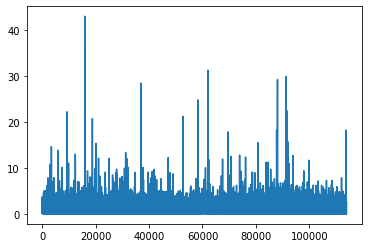

In [ ]:
# 각 관측치의 k-거리에 대한 플롯 평균 
plt.plot(distances.mean(axis =1))

In [ ]:
len(train_data)* 0.001

113.842

In [ ]:
# 컷오프 값을 시각적으로 결정 > 0.15 
outlier_index = np.where(distances.mean(axis = 1) > 0.0001) 
len(train_data), len(outlier_index[0])

(113842, 113665)

In [ ]:
distances.mean(axis = 1)

array([1.84879863, 1.00949589, 0.57205977, ..., 0.38016076, 0.12311865,
       0.87926642])

In [ ]:
# 이상값 필터링 
outlier_values = train_data.iloc[outlier_index[0]].copy()
outlier_values

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-0.696317,-0.812481,1.178089,0.271798,-0.368309,1.349308,0.652511,0.210988,-1.380804,0.188955,...,0.345210,1.066111,1.431834,-1.136246,-0.633230,-0.288586,-0.137969,-0.166355,1.188563,-1.990839
1,-0.495358,-0.112967,1.191305,-0.608173,-0.007886,0.933476,0.192541,0.320444,-1.264291,-0.056156,...,-0.148280,0.007285,-0.297148,-1.938909,1.241563,-0.460803,0.157587,0.173998,0.143876,-1.990839
2,-0.218427,0.580982,0.755819,-0.116154,0.307498,-0.026206,0.390690,0.221649,-0.517216,-0.351540,...,-0.286720,-0.773425,-0.039431,-0.611606,-0.450853,0.220818,0.635984,0.229098,-0.346737,-1.990818
3,-0.330318,0.858041,0.711241,-0.345477,0.693558,0.317890,0.925884,-3.209968,0.563699,1.161326,...,2.693508,-1.402900,0.092477,-1.070930,-0.801717,-0.106743,-3.020466,-3.046182,-0.194717,-1.990712
4,-0.458462,0.172537,-0.082109,-0.189262,1.951788,2.793282,0.302611,0.719980,-0.355977,-0.387965,...,-0.099976,-0.370382,-0.319020,1.671161,0.714378,-0.798093,0.029990,0.401295,0.019821,-1.990712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113836,-0.649279,-0.243329,0.632305,-0.509511,1.119918,-1.348093,0.256599,0.006035,0.014573,-0.766447,...,-0.216883,-1.220412,0.141187,-0.125288,-0.187500,0.276548,-0.070673,0.356618,-0.358119,1.645794
113837,-6.415477,6.169704,-5.669274,-1.774215,-3.354334,-1.051879,-3.021567,4.640268,4.468824,8.074160,...,-1.306812,-2.162159,1.402375,-2.067159,3.432320,0.667510,5.233857,3.463283,-0.321352,1.645815
113838,0.965967,-0.087719,-0.674497,1.069597,-0.026160,-0.465046,0.153202,-0.208020,0.610333,0.107995,...,0.201179,0.876793,-0.064140,-0.086360,0.605158,-0.958774,0.046304,-0.113892,-0.116108,1.645857
113839,-0.124097,0.430608,0.260596,-0.325094,0.178465,-1.013702,0.767042,-0.171877,0.098905,-0.270613,...,-0.315282,-0.710635,0.441651,0.614549,-1.078550,0.235849,0.329761,0.229617,-0.339285,1.645899
